In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

np.random.seed = 42

df=pd.read_csv('../data/players_away_matches.csv')

#removing id and names and saving df without them
df = df.drop(df.columns[0], axis=1)
df.drop(columns=['playerName'], inplace=True)
df.drop(columns=['team_name'], inplace=True)

X_mod, X_val = train_test_split(df, test_size=0.3, random_state=42)

X_val.to_csv('../data/for_validators/soccer_players_validators.csv', index=False)
X_mod.to_csv('../data/for_modellers/soccer_players_modellers.csv', index=False)
df=pd.read_csv('../data/for_modellers/soccer_players_modellers.csv')

### In this milestone:
1. Data Preprocessing:
- removing some columns
- NULL/missing values (deleting or mean or another strategy)
- encoding of categorical columns (one hot encoding, ordinal encoding, ...)
- data transformation
- scaling/standarizing variables (in which models)
- outliers 
- function for preprocessing for validators
2. Pre-modelling

# 1. Data Preprocessing

## 1.1 Removing columns

## 1.2 Missing values

In [254]:
null_columns = df.columns[df.isnull().any()]

# Print the null columns
print("Null columns:")
print(null_columns)

Null columns:
Index(['aerials_lost', 'aerials_won', 'aerials_won_pct', 'assisted_shots',
       'ball_recoveries', 'blocked_passes', 'blocked_shots',
       'blocked_shots_saves', 'blocks', 'carries', 'carries_into_final_third',
       'carries_into_penalty_area', 'carry_distance',
       'carry_progressive_distance', 'clearances', 'corner_kicks',
       'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight',
       'crosses_into_penalty_area', 'dispossessed', 'dribble_tackles',
       'dribble_tackles_pct', 'dribbled_past', 'dribbles',
       'dribbles_completed', 'dribbles_completed_pct', 'dribbles_vs', 'errors',
       'gca', 'minutes', 'miscontrols', 'npxg', 'nutmegs', 'pass_targets',
       'passes', 'passes_blocked', 'passes_completed', 'passes_completed_long',
       'passes_completed_medium', 'passes_completed_short', 'passes_dead',
       'passes_free_kicks', 'passes_ground', 'passes_head', 'passes_high',
       'passes_intercepted', 'passes_into_final_third',
       '

In [255]:
null_cols_count = df.isnull().any().sum()

print("Number of columns with null values:", null_cols_count)

Number of columns with null values: 99


In [256]:

print("Null counts for each column:")
df.isnull().sum().sort_values(ascending=False).head(20)


Null counts for each column:


dribbles_completed_pct         26447
dribble_tackles_pct            23101
aerials_won_pct                15866
passes_pct_long                 7057
pressure_regain_pct             4735
passes_pct_medium               2492
passes_pct_short                2240
pens_won                        2099
pens_conceded                   2099
passes_pct                       610
passes_received_pct              516
championship_name                459
progressive_carries               71
carries_into_final_third          71
carries_into_penalty_area         71
throw_ins                         50
passes_oob                        50
touches_def_pen_area              50
passes_received                   50
passes_progressive_distance       50
dtype: int64

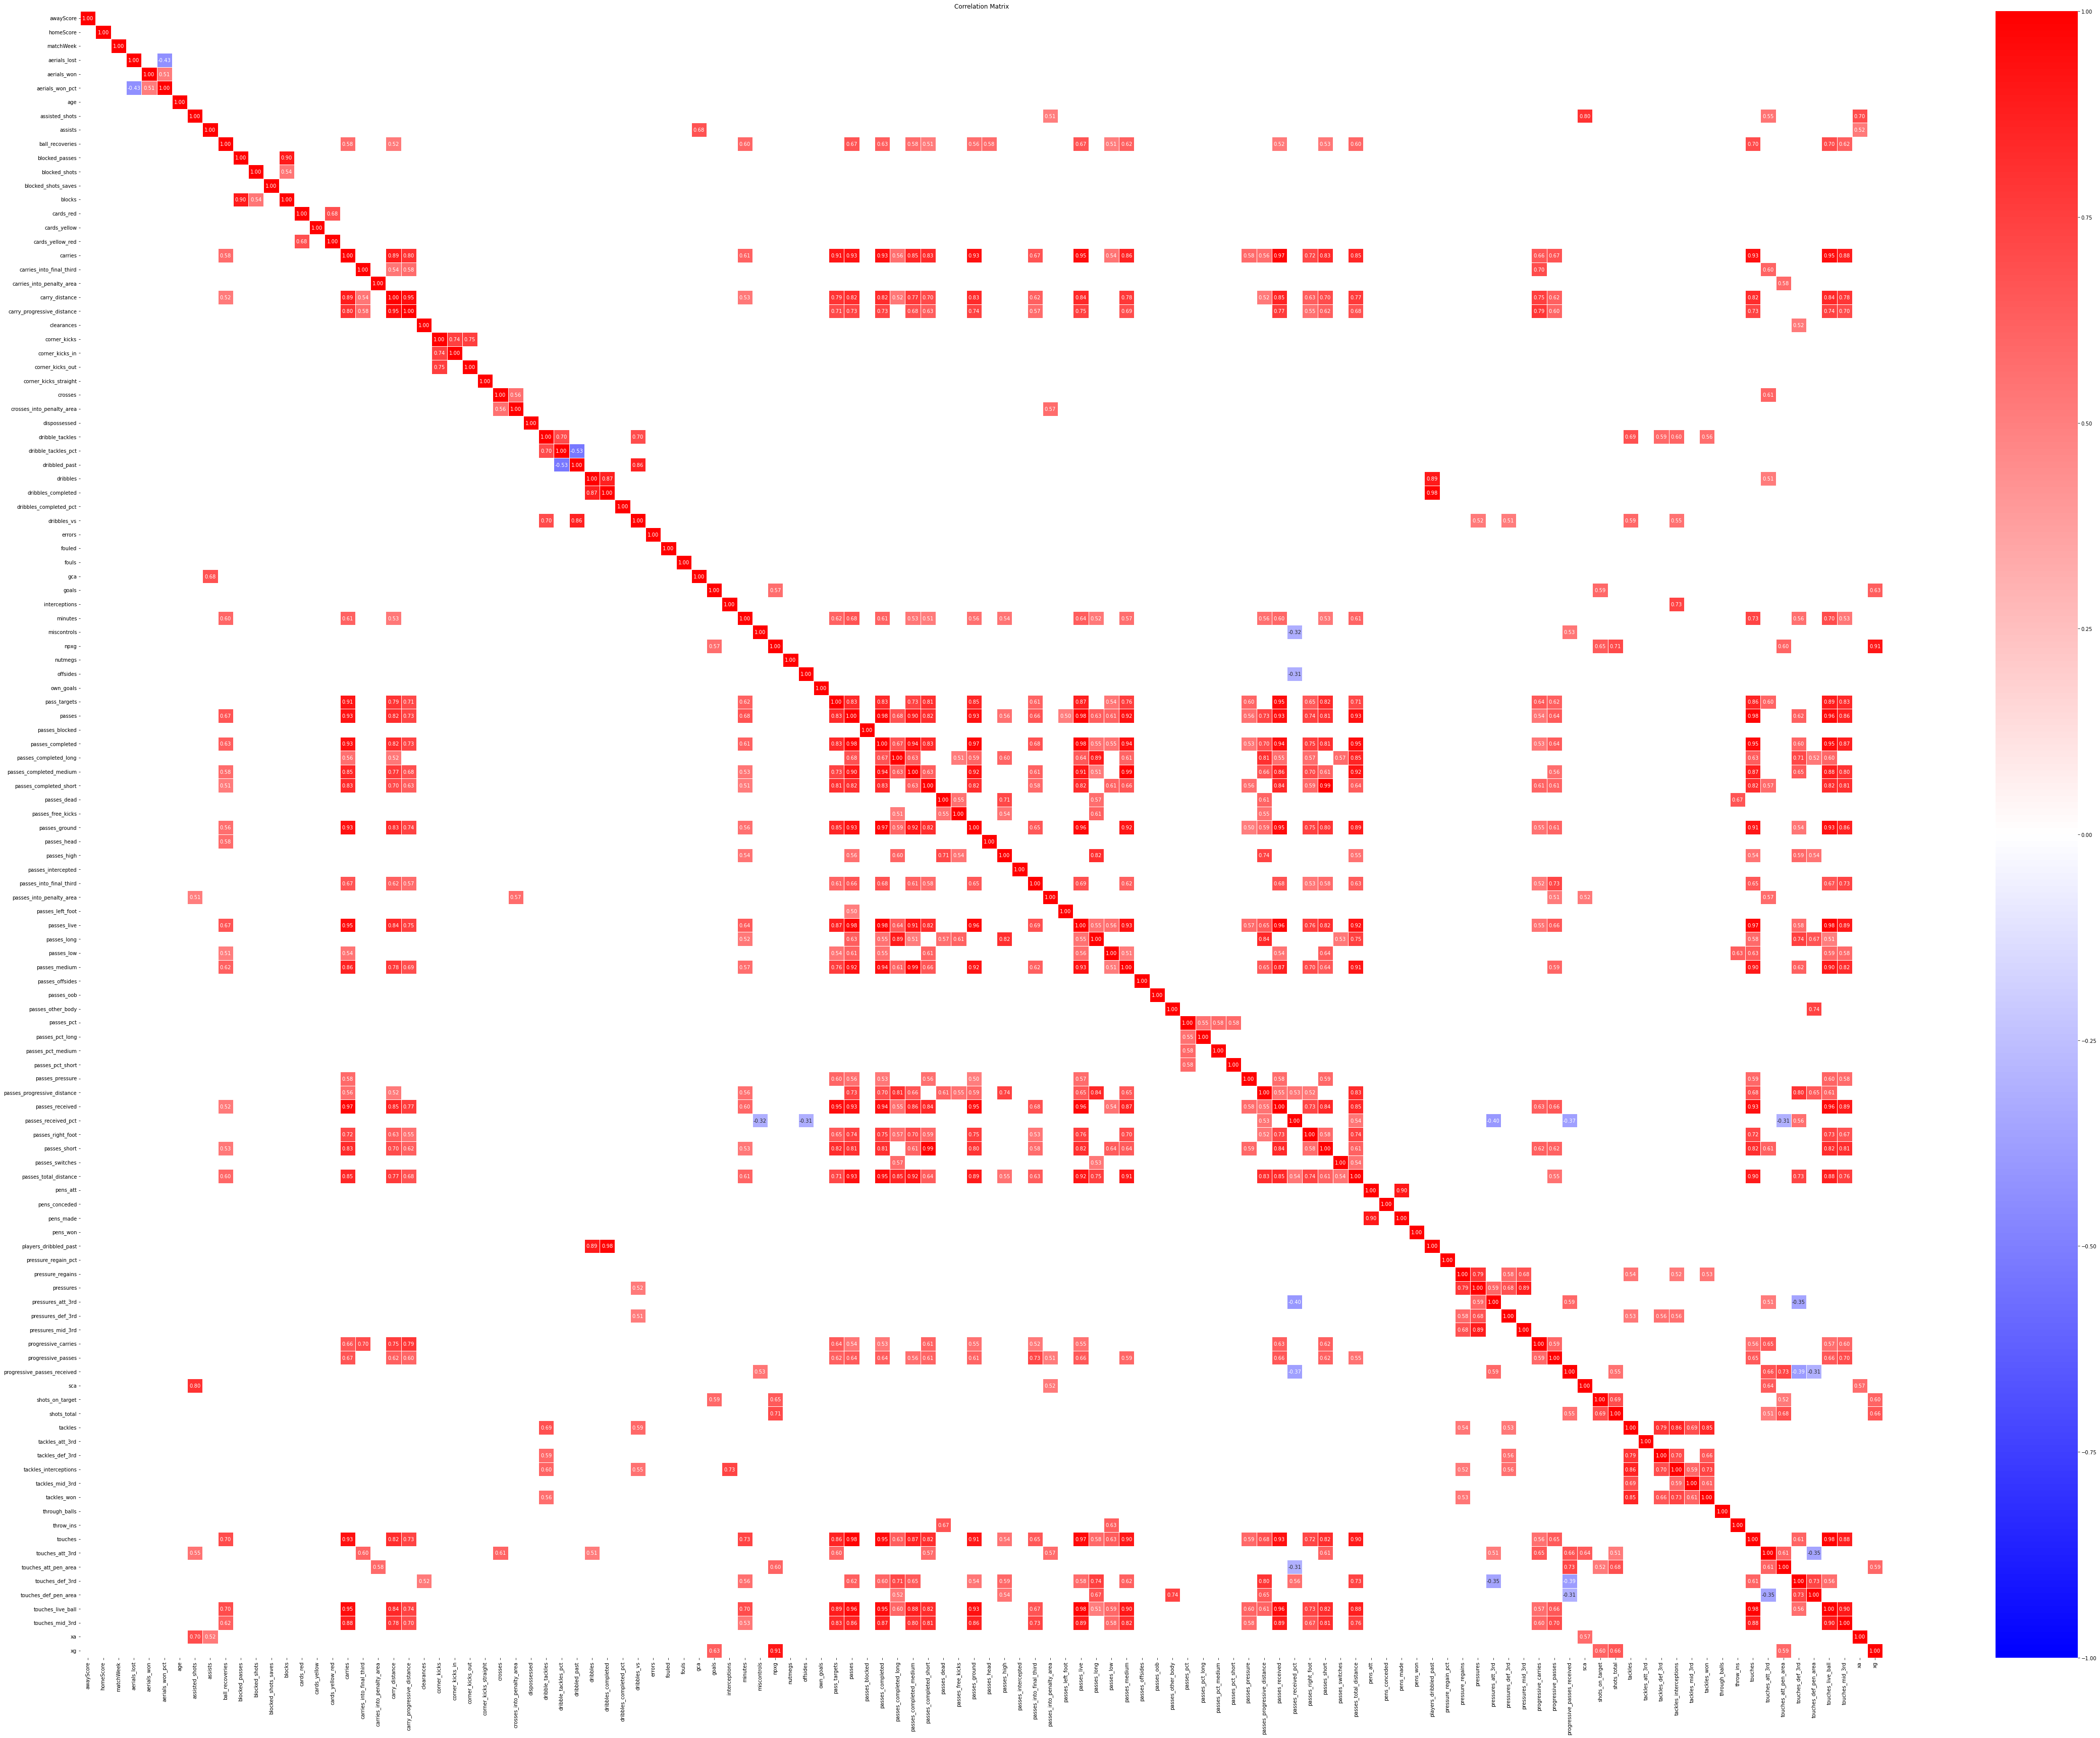

In [257]:
from matplotlib.colors import LinearSegmentedColormap

numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()
fcorr = corr[(corr > 0.5) | (corr < -0.3)]
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["blue", "white", "red"])

# Plot the correlation matrix
plt.figure(figsize=(80, 60))
sns.heatmap(fcorr, annot=True, cmap=cmap, vmin=-1, vmax=1, center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


We are searching for columns to delete

In [258]:
df.filter(regex='pct').columns

Index(['aerials_won_pct', 'dribble_tackles_pct', 'dribbles_completed_pct',
       'passes_pct', 'passes_pct_long', 'passes_pct_medium',
       'passes_pct_short', 'passes_received_pct', 'pressure_regain_pct'],
      dtype='object')

In [259]:
df[['aerials_won','aerials_lost','aerials_won_pct']]

aerials_won  aerials_lost  aerials_won_pct
0              0.0           0.0              NaN
1              1.0           0.0            100.0
2              1.0           0.0            100.0
3              1.0           0.0            100.0
4              0.0           3.0              0.0
...            ...           ...              ...
53324          0.0           0.0              NaN
53325          1.0           2.0             33.3
53326          0.0           1.0              0.0
53327          0.0           0.0              NaN
53328          1.0           1.0             50.0

[53329 rows x 3 columns]

Firstly, we delete columns with 'pct' in their names because they represent the percentage of some statistic that is already included in other columns.

In [260]:
col_drop = df.filter(regex='pct').columns
df.drop(columns=col_drop, inplace=True)

Now, we delete columns with high correlation coefficients, as well as those that represent redundant information already captured by other columns


In [261]:
threshold = 0.7
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

high_correlation_matrix = corr[(abs(corr) > threshold) & (corr != 1.0)]

for column in high_correlation_matrix.columns:
    highest_correlations = high_correlation_matrix[column].dropna()
    if not highest_correlations.empty:
        print(f"Highest correlations for column '{column}':")
        print(highest_correlations)
        print()

Highest correlations for column 'assisted_shots':
sca    0.802385
xa     0.700308
Name: assisted_shots, dtype: float64

Highest correlations for column 'blocked_passes':
blocks    0.895996
Name: blocked_passes, dtype: float64

Highest correlations for column 'blocks':
blocked_passes    0.895996
Name: blocks, dtype: float64

Highest correlations for column 'carries':
carry_distance                0.887823
carry_progressive_distance    0.797673
pass_targets                  0.910050
passes                        0.928569
passes_completed              0.931741
passes_completed_medium       0.845934
passes_completed_short        0.834066
passes_ground                 0.934277
passes_live                   0.950182
passes_medium                 0.862063
passes_received               0.970124
passes_right_foot             0.718032
passes_short                  0.828325
passes_total_distance         0.846310
touches                       0.933470
touches_live_ball             0.949898
touches

passes, touches, carries(carr), dribbles(dribble), corner, blocks(block)

In [262]:
passes_columns = df.filter(regex='passes').columns
arr_passes = list()
for col in passes_columns:
    if abs(df[col].corr(df['passes'])) > 0.6:
        arr_passes.append(col)
arr_passes.pop(0)
arr_passes

['passes_completed',
 'passes_completed_long',
 'passes_completed_medium',
 'passes_completed_short',
 'passes_ground',
 'passes_into_final_third',
 'passes_live',
 'passes_long',
 'passes_low',
 'passes_medium',
 'passes_progressive_distance',
 'passes_received',
 'passes_right_foot',
 'passes_short',
 'passes_total_distance',
 'progressive_passes']

In [263]:
touches_columns = df.filter(regex='touches').columns
arr_touches = list()
for col in touches_columns:
    if abs(df[col].corr(df['touches'])) > 0.6:
        arr_touches.append(col)
arr_touches.pop(0)
arr_touches

['touches_def_3rd', 'touches_live_ball', 'touches_mid_3rd']

In [264]:
carr_columns = df.filter(regex='carr').columns
arr_carr = list()
for col in carr_columns:
    if abs(df[col].corr(df['carries'])) > 0.6:
        arr_carr.append(col)
arr_carr.pop(0)
arr_carr

['carry_distance', 'carry_progressive_distance', 'progressive_carries']

In [265]:
dribble_columns = df.filter(regex='dribble').columns
arr_dribble = list()
for col in dribble_columns:
    if abs(df[col].corr(df['dribbles'])) > 0.6:
        arr_dribble.append(col)
arr_dribble.pop(0)
arr_dribble

['dribbles_completed', 'players_dribbled_past']

In [266]:
corner_columns = df.filter(regex='corner').columns
arr_corner = list()
for col in corner_columns:
    if abs(df[col].corr(df['corner_kicks'])) > 0.6:
        arr_corner.append(col)
arr_corner.pop(0)
arr_corner

['corner_kicks_in', 'corner_kicks_out']

In [267]:
block_columns = df.filter(regex='block').columns
arr_block = list()
for col in block_columns:
    if abs(df[col].corr(df['blocks'])) > 0.6:
        arr_block.append(col)
arr_block.pop(1)
arr_block

['blocked_passes']

In [268]:
cols_to_drop = arr_passes+arr_touches+arr_carr+arr_dribble+arr_corner+arr_block
df.drop(columns=cols_to_drop, inplace=True)


In [269]:
threshold = 0.7
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

high_correlation_matrix = corr[(abs(corr) > threshold) & (corr != 1.0)]

for column in high_correlation_matrix.columns:
    highest_correlations = high_correlation_matrix[column].dropna()
    if not highest_correlations.empty:
        print(f"Highest correlations for column '{column}':")
        print(highest_correlations)
        print()
        


Highest correlations for column 'assisted_shots':
sca    0.802385
xa     0.700308
Name: assisted_shots, dtype: float64

Highest correlations for column 'carries':
pass_targets    0.910050
passes          0.928569
touches         0.933470
Name: carries, dtype: float64

Highest correlations for column 'dribble_tackles':
dribbles_vs    0.700013
Name: dribble_tackles, dtype: float64

Highest correlations for column 'dribbled_past':
dribbles_vs    0.862981
Name: dribbled_past, dtype: float64

Highest correlations for column 'dribbles_vs':
dribble_tackles    0.700013
dribbled_past      0.862981
Name: dribbles_vs, dtype: float64

Highest correlations for column 'interceptions':
tackles_interceptions    0.72691
Name: interceptions, dtype: float64

Highest correlations for column 'minutes':
touches    0.734107
Name: minutes, dtype: float64

Highest correlations for column 'npxg':
shots_total    0.710451
xg             0.911297
Name: npxg, dtype: float64

Highest correlations for column 'pass_ta

In [270]:
cols_to_drop2 =  ['xg', 'tackles_def_3rd', 'tackles_won', 'tackles_interceptions', 'npxg', 'sca', 'xa', 'pass_targets', 'dribble_tackles', 'dribbled_past', 'tackles_interceptions', 'pens_made', 'pressure_regains', 'pressures_mid_3rd']

df.drop(columns=cols_to_drop2, inplace=True)

cols_to_drop3 = ['touches','carries']
df.drop(columns=cols_to_drop3, inplace=True)


In [271]:

print("Null counts for each column:")
df.isnull().sum().sort_values(ascending=False).head(20)

Null counts for each column:


pens_won                     2099
pens_conceded                2099
championship_name             459
carries_into_penalty_area      71
carries_into_final_third       71
passes_other_body              50
dribbles                       50
dribbles_vs                    50
errors                         50
gca                            50
passes_switches                50
passes_pressure                50
miscontrols                    50
crosses_into_penalty_area      50
nutmegs                        50
passes_oob                     50
passes_offsides                50
passes                         50
passes_blocked                 50
passes_dead                    50
dtype: int64

In [272]:
null_cols_count = df.isnull().any().sum()

print("Number of columns with null values:", null_cols_count)

Number of columns with null values: 50


In [273]:
df[df['passes'].isna()]

awayScore         awayTeamName awayTeamTacticalSchema  homeScore  \
61             1           Valladolid                (4-4-2)          4   
2312           0       Rayo Vallecano              (4-2-3-1)          1   
2709           1               Spezia                (4-3-3)          2   
4964           2               Spezia                (4-3-3)          2   
5378           0           Valladolid                (4-4-2)          2   
5732           2               Alavés                (4-3-3)          0   
6520           0             Toulouse              (4-1-4-1)          1   
7975           1           Villarreal              (4-4-1-1)          1   
9177           1               Rennes                (4-4-2)          0   
9558           1           Valladolid                (4-4-2)          4   
10799          2                Genoa                (3-5-2)          1   
11526          0               Getafe              (4-2-2-2)          0   
13297          1            Marseille                (3-4-3)          1   
13325          1            Marseille                (3-4-3)          1   
13959          2               Napoli              (4-2-3-1)          0   
15550          1           Valladolid                (4-4-2)          1   
15605          2           Celta Vigo                (4-3-3)          3   
16643          1       Leicester City                (3-4-3)          2   
16746          1       Rayo Vallecano              (4-2-3-1)          1   
19130          0              Levante                (3-5-2)          2   
22168          1            Stuttgart                (3-5-2)          1   
23217          1             Nürnberg              (4-2-2-2)          2   
24577          2               Spezia                (4-4-2)          2   
26189          1       Internazionale              (4-2-3-1)          2   
27603          0           Real Betis              (4-1-4-1)          1   
28068          1           Valladolid                (4-4-2)          1   
28831          1               Spezia                (4-3-3)          4   
30267          1            Marseille                (3-4-3)          1   
30975          0              Osasuna                (4-5-1)          2   
31110          2              Levante                (4-4-2)          2   
33383          0             Espanyol              (4-1-4-1)          1   
35395          1            Marseille                (3-4-3)          1   
35886          3       Internazionale                (3-5-2)          1   
35907          2               Spezia                (4-3-3)          2   
36248          1               Spezia                (3-4-3)          6   
37849          2       Rayo Vallecano              (4-2-3-1)          1   
39549          0           Real Betis              (4-2-3-1)          1   
40371          1           Valladolid                (4-4-2)          1   
43149          0       Internazionale                (3-5-2)          2   
43296          0           Celta Vigo                (4-3-3)          0   
43672          3  Eintracht Frankfurt              (3-4-1-2)          0   
43698          2                Milan                (4-3-3)          1   
44826          0             Espanyol                (3-5-2)          1   
45483          1           Real Betis              (4-1-4-1)          1   
45986          2      Atlético Madrid                (3-5-2)          1   
46276          2             Mallorca              (4-1-4-1)          4   
47642          1              Levante                (4-4-2)          2   
49736          1               Empoli                (3-5-2)          2   
51827          1            Barcelona                (3-4-3)          2   
51934          2              Levante                (4-4-2)          4   

          homeTeamName homeTeamTacticalSchema   matchDate  matchWeek  \
61       Real Sociedad                (4-4-2)  2021-05-16         37   
2312     Real Sociedad              (

It turns out that all 50 rows that contains missing values are matches with no given statistics 

In [274]:
df.dropna(subset=['passes'],inplace=True)

In [275]:
null_cols_count = df.isnull().any().sum()

print("Number of columns with null values:", null_cols_count)

Number of columns with null values: 6


In [276]:

print("Null counts for each column:")
df.isnull().sum().sort_values(ascending=False)

Null counts for each column:


pens_won                     2053
pens_conceded                2053
championship_name             459
carries_into_final_third       21
carries_into_penalty_area      21
                             ... 
goals                           0
interceptions                   0
awayTeamName                    0
miscontrols                     0
awayScore                       0
Length: 73, dtype: int64

In [301]:
df['pens_won'].fillna(0, inplace=True)
df['pens_conceded'].fillna(0, inplace=True)
df['minutes'].fillna(90, inplace=True)
df['carries_into_final_third'].fillna(0, inplace=True)
df['carries_into_penalty_area'].fillna(0, inplace=True)

df['championship_name'].fillna('unknown', inplace=True)

In [303]:
null_cols_count = df.isnull().any().sum()

print("Number of columns with null values:", null_cols_count)

Number of columns with null values: 0


0 NULLs left - 1.2 done:)

## 1.3 Encoding of categorical values

Here we know from EDA that we have some categorical columns that have a lot of different unstructured values - we need to think about what to do with this

In [304]:
cat_cols = df.select_dtypes(include='object').columns

print(f'categorical columns: {cat_cols}')
print(f'number of categorical columns: {len(cat_cols)}')

categorical columns: Index(['awayTeamName', 'awayTeamTacticalSchema', 'homeTeamName',
       'homeTeamTacticalSchema', 'matchDate', 'championship_name'],
      dtype='object')
number of categorical columns: 6


In [305]:
unique_values_count = df[cat_cols].nunique()
print(unique_values_count)

awayTeamName              129
awayTeamTacticalSchema     32
homeTeamName              122
homeTeamTacticalSchema     32
matchDate                 565
championship_name           6
dtype: int64


In [306]:
unique_values = df['awayTeamTacticalSchema'].unique()
print(unique_values)

['(4-4-2)' '(4-2-3-1)' '(3-5-2)' '(4-5-1)' '(3-4-1-2)' '(4-1-4-1)'
 '(4-3-3)' '(3-4-3)' '(5-1-2-2)' '(4-4-2◆)' '(4-4-1-1)' '(4-2-2-2)'
 '(3-5-1-1)' '(3-2-2-2-1)' '(3-2-3-1-1)' '(4-1-3-2)' '(3-2-2-1-2)'
 '(5-3-2)' '(5-4-1)' '(3-2-3-2)' '(4-2-3-1◆)' '(4-3-2-1)' '(3-1-4-1-1)'
 '(4-2-2-1-1)' '(4-3-1-2)' '(3-1-4-2)' '(3-4-3◆)' '(3-3-2-2)' '(3-2-4-1)'
 '(3-3-2-1-1)' 'United' 'Marseille']


We have some incorrect values here, let's change/remove them.

In [307]:
df[df['awayTeamTacticalSchema']=='United']

awayScore  awayTeamName awayTeamTacticalSchema  homeScore homeTeamName  \
4286           1  Leeds United                 United          1      Burnley   
22856          1  Leeds United                 United          1      Burnley   
47938          1  Leeds United                 United          1      Burnley   
48081          1  Leeds United                 United          1      Burnley   
48988          1  Leeds United                 United          1      Burnley   
53264          1  Leeds United                 United          1      Burnley   

      homeTeamTacticalSchema   matchDate  matchWeek  aerials_lost  \
4286                 (4-4-2)  2021-08-29          3           5.0   
22856                (4-4-2)  2021-08-29          3           3.0   
47938                (4-4-2)  2021-08-29          3           4.0   
48081                (4-4-2)  2021-08-29          3           0.0   
48988                (4-4-2)  2021-08-29          3           0.0   
53264                (4-4-2)  2021-08-29          3           3.0   

       aerials_won  ...  shots_total  tackles  tackles_att_3rd  \
4286           4.0  ...            0      1.0              0.0   
22856          1.0  ...            3      0.0              0.0   
47938          2.0  ...            0      0.0              0.0   
48081          0.0  ...            0      0.0              0.0   
48988          0.0  ...            2      0.0              0.0   
53264          5.0  ...            1      0.0              0.0   

       tackles_mid_3rd  through_balls  throw_ins  touches_att_3rd  \
4286               0.0            0.0        0.0              0.0   
22856              0.0            0.0        0.0             14.0   
47938              0.0            0.0        3.0             19.0   
48081              0.0            0.0        0.0              0.0   
48988              0.0            0.0        1.0              7.0   
53264              0.0            0.0        0.0              5.0   

       touches_att_pen_area  touches_def_pen_area  championship_name  
4286                    0.0                  12.0     premier league  
22856                  10.0                   1.0     premier league  
47938                   1.0                   2.0     premier league  
48081                   0.0                  44.0     premier league  
48988                   2.0                   0.0     premier league  
53264                   2.0                   6.0     premier league  

[6 rows x 73 columns]

In [308]:
df[df['awayTeamTacticalSchema']=='Marseille']

awayScore awayTeamName awayTeamTacticalSchema  homeScore homeTeamName  \
14150          0    Marseille              Marseille          2        Lille   
15110          0    Marseille              Marseille          2        Lille   
18643          0    Marseille              Marseille          2        Lille   
19562          0    Marseille              Marseille          2        Lille   
24063          0    Marseille              Marseille          2        Lille   
25665          0    Marseille              Marseille          2        Lille   
27168          0    Marseille              Marseille          2        Lille   
33450          0    Marseille              Marseille          2        Lille   
41038          0    Marseille              Marseille          2        Lille   

      homeTeamTacticalSchema   matchDate  matchWeek  aerials_lost  \
14150                (4-4-2)  2021-10-03          9           0.0   
15110                (4-4-2)  2021-10-03          9           0.0   
18643                (4-4-2)  2021-10-03          9           2.0   
19562                (4-4-2)  2021-10-03          9           0.0   
24063                (4-4-2)  2021-10-03          9           0.0   
25665                (4-4-2)  2021-10-03          9           1.0   
27168                (4-4-2)  2021-10-03          9           1.0   
33450                (4-4-2)  2021-10-03          9           0.0   
41038                (4-4-2)  2021-10-03          9           0.0   

       aerials_won  ...  shots_total  tackles  tackles_att_3rd  \
14150          2.0  ...            2      0.0              0.0   
15110          0.0  ...            1      1.0              0.0   
18643          0.0  ...            0      1.0              1.0   
19562          0.0  ...            0      0.0              0.0   
24063          0.0  ...            0      1.0              0.0   
25665          0.0  ...            2      0.0              0.0   
27168          2.0  ...            1      1.0              0.0   
33450          0.0  ...            0      1.0              0.0   
41038          1.0  ...            0      6.0              0.0   

       tackles_mid_3rd  through_balls  throw_ins  touches_att_3rd  \
14150              0.0            0.0        0.0             10.0   
15110              1.0            0.0        1.0             29.0   
18643              0.0            0.0        8.0             18.0   
19562              0.0            0.0        0.0             14.0   
24063              0.0            0.0        0.0              0.0   
25665              0.0            0.0        0.0              5.0   
27168              0.0            0.0        3.0             13.0   
33450              1.0            0.0        6.0             26.0   
41038              1.0            0.0        0.0              9.0   

       touches_att_pen_area  touches_def_pen_area  championship_name  
14150                   5.0                   1.0            ligue 1  
15110                   1.0                   0.0            ligue 1  
18643                   1.0                   7.0            ligue 1  
19562                   1.0                   0.0            ligue 1  
24063                   0.0                   7.0            ligue 1  
25665                   3.0                   0.0            ligue 1  
27168                   1.0                   0.0            ligue 1  
33450                   2.0                   0.0            ligue 1  
41038                   0.0                   9.0            ligue 1  

[9 rows x 73 columns]

In [309]:
#let's remove rows with teamNames as tactical schema
df = df[(df['awayTeamTacticalSchema'] != 'United') & (df['awayTeamTacticalSchema'] != 'Marseille')]


In [310]:
unique_values = df['awayTeamTacticalSchema'].unique()
print(unique_values)

['(4-4-2)' '(4-2-3-1)' '(3-5-2)' '(4-5-1)' '(3-4-1-2)' '(4-1-4-1)'
 '(4-3-3)' '(3-4-3)' '(5-1-2-2)' '(4-4-2◆)' '(4-4-1-1)' '(4-2-2-2)'
 '(3-5-1-1)' '(3-2-2-2-1)' '(3-2-3-1-1)' '(4-1-3-2)' '(3-2-2-1-2)'
 '(5-3-2)' '(5-4-1)' '(3-2-3-2)' '(4-2-3-1◆)' '(4-3-2-1)' '(3-1-4-1-1)'
 '(4-2-2-1-1)' '(4-3-1-2)' '(3-1-4-2)' '(3-4-3◆)' '(3-3-2-2)' '(3-2-4-1)'
 '(3-3-2-1-1)']


In [311]:
df.loc[df['awayTeamTacticalSchema'] == '(4-4-2◆)', 'awayTeamTacticalSchema'] = '(4-4-2)'
df.loc[df['awayTeamTacticalSchema'] == '(4-2-3-1◆)', 'awayTeamTacticalSchema'] = '(4-2-3-1)'
df.loc[df['awayTeamTacticalSchema'] == '(3-4-3◆)', 'awayTeamTacticalSchema'] = '(3-4-3)'


In [312]:
unique_values = df['awayTeamTacticalSchema'].unique()
print(unique_values)

['(4-4-2)' '(4-2-3-1)' '(3-5-2)' '(4-5-1)' '(3-4-1-2)' '(4-1-4-1)'
 '(4-3-3)' '(3-4-3)' '(5-1-2-2)' '(4-4-1-1)' '(4-2-2-2)' '(3-5-1-1)'
 '(3-2-2-2-1)' '(3-2-3-1-1)' '(4-1-3-2)' '(3-2-2-1-2)' '(5-3-2)' '(5-4-1)'
 '(3-2-3-2)' '(4-3-2-1)' '(3-1-4-1-1)' '(4-2-2-1-1)' '(4-3-1-2)'
 '(3-1-4-2)' '(3-3-2-2)' '(3-2-4-1)' '(3-3-2-1-1)']


Now the same for homeTeamTacticalSchema.

In [313]:
unique_values = df['homeTeamTacticalSchema'].unique()
print(unique_values)

['(4-3-3)' '(4-2-3-1)' '(4-4-2)' '(3-5-2)' '(4-1-4-1)' '(4-4-2◆)'
 '(3-4-3)' '(5-1-2-2)' '(3-5-1-1)' '(4-4-1-1)' '(3-4-1-2)' '(4-5-1)'
 '(3-1-4-2)' '(4-2-2-2)' '(5-3-2)' '(4-3-2-1)' '(3-2-4-1)' '(3-2-2-1-2)'
 '(3-3-2-2)' '(3-2-1-2-2)' '(3-4-3◆)' '(3-2-3-1-1)' '(3-2-2-2-1)'
 '(4-1-3-2)' '(3-2-3-2)' '(4-3-1-2)' '(5-4-1)' '(3-1-4-1-1)' '(4-2-2-1-1)'
 '(4-2-3-1◆)' '(3-5-2◆)' '(4-3-3◆)']


In [314]:
df.loc[df['homeTeamTacticalSchema'] == '(4-4-2◆)', 'homeTeamTacticalSchema'] = '(4-4-2)'
df.loc[df['homeTeamTacticalSchema'] == '(4-2-3-1◆)', 'homeTeamTacticalSchema'] = '(4-2-3-1)'
df.loc[df['homeTeamTacticalSchema'] == '(3-4-3◆)', 'homeTeamTacticalSchema'] = '(3-4-3)'
df.loc[df['homeTeamTacticalSchema'] == '(3-5-2◆)', 'homeTeamTacticalSchema'] = '(3-5-2)'
df.loc[df['homeTeamTacticalSchema'] == '(4-3-3◆)', 'homeTeamTacticalSchema'] = '(4-3-3)'

In [315]:
unique_values = df['homeTeamTacticalSchema'].unique()
print(unique_values)

['(4-3-3)' '(4-2-3-1)' '(4-4-2)' '(3-5-2)' '(4-1-4-1)' '(3-4-3)'
 '(5-1-2-2)' '(3-5-1-1)' '(4-4-1-1)' '(3-4-1-2)' '(4-5-1)' '(3-1-4-2)'
 '(4-2-2-2)' '(5-3-2)' '(4-3-2-1)' '(3-2-4-1)' '(3-2-2-1-2)' '(3-3-2-2)'
 '(3-2-1-2-2)' '(3-2-3-1-1)' '(3-2-2-2-1)' '(4-1-3-2)' '(3-2-3-2)'
 '(4-3-1-2)' '(5-4-1)' '(3-1-4-1-1)' '(4-2-2-1-1)']


We will transform these values into 3 columns: defense_schema (nr of players in defense), middle_schema, strikers_schema.

In [316]:
print(df['homeTeamTacticalSchema'].nunique())

27


In [317]:
def extract_numbers(formation):
    nums = formation.strip('()').split('-')
    nums = [int(num) for num in nums]
    while len(nums) < 3:
        nums.append(0)
    return nums

formations_home = [extract_numbers(formation) for formation in df['homeTeamTacticalSchema']]
formations_home

[[4, 3, 3],
 [4, 2, 3, 1],
 [4, 3, 3],
 [4, 4, 2],
 [3, 5, 2],
 [3, 5, 2],
 [4, 3, 3],
 [4, 1, 4, 1],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 3, 3],
 [3, 4, 3],
 [4, 3, 3],
 [4, 3, 3],
 [4, 4, 2],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [4, 2, 3, 1],
 [3, 5, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 3, 3],
 [3, 5, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 2, 3, 1],
 [3, 4, 3],
 [4, 2, 3, 1],
 [3, 4, 3],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 3, 3],
 [3, 4, 3],
 [4, 4, 2],
 [4, 4, 2],
 [4, 1, 4, 1],
 [4, 3, 3],
 [4, 3, 3],
 [4, 1, 4, 1],
 [4, 2, 3, 1],
 [5, 1, 2, 2],
 [4, 3, 3],
 [4, 3, 3],
 [4, 3, 3],
 [3, 5, 1, 1],
 [3, 4, 3],
 [3, 5, 2],
 [3, 5, 2],
 [4, 4, 2],
 [3, 4, 3],
 [3, 4, 3],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [3, 4, 3],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 4, 1, 1],
 [4, 2, 3, 1],
 [4, 3, 3],
 [4, 2, 3, 1],
 [3, 4, 3],
 [4, 1, 4, 1],
 [3, 4, 3],
 [3, 5, 2],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [4, 4, 2],
 [3, 4, 3],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4,

In [318]:
#count nr of middle players
def sum_middle_values(formation):
    return sum(formation[1:-1])

df['defense_schema_home'] = [form[0] for form in formations_home]
df['middle_schema_home'] = [sum_middle_values(form) for form in formations_home]
df['strikers_schema_home'] = [form[-1] for form in formations_home]


In [319]:
df.drop(columns=['homeTeamTacticalSchema'], inplace=True)
df.head()

awayScore    awayTeamName awayTeamTacticalSchema  homeScore  homeTeamName  \
0          4          Napoli                (4-4-2)          1        Spezia   
1          4   Bayern Munich              (4-2-3-1)          0    Schalke 04   
2          0         Osasuna                (3-5-2)          0       Levante   
3          2  Crystal Palace                (4-5-1)          2       Arsenal   
4          0      Hertha BSC              (4-2-3-1)          2  Union Berlin   

    matchDate  matchWeek  aerials_lost  aerials_won   age  ...  \
0  2021-05-08         35           0.0          0.0  24.0  ...   
1  2021-01-24         18           0.0          1.0  20.0  ...   
2  2021-12-05         16           0.0          1.0  23.0  ...   
3  2019-10-27         10           0.0          1.0  28.0  ...   
4  2021-11-20         12           3.0          0.0  24.0  ...   

   tackles_mid_3rd  through_balls  throw_ins  touches_att_3rd  \
0              0.0            0.0        0.0              0.0   
1              3.0            0.0        4.0             20.0   
2              2.0            0.0        0.0             14.0   
3              1.0            0.0        0.0              9.0   
4              0.0            0.0        0.0             16.0   

   touches_att_pen_area  touches_def_pen_area  championship_name  \
0                   0.0                  42.0            seria a   
1                   0.0                   4.0         bundesliga   
2                   0.0                   3.0               liga   
3                   1.0                   6.0     premier league   
4                   2.0                   1.0         bundesliga   

   defense_schema_home  middle_schema_home  strikers_schema_home  
0                    4                   3                     3  
1                    4                   5                     1  
2                    4                   3                     3  
3                    4                   4                     2  
4                    3                   5                     2  

[5 rows x 75 columns]

In [320]:
print(df['awayTeamTacticalSchema'].nunique())

27


In [321]:
formations_away = [extract_numbers(formation) for formation in df['awayTeamTacticalSchema']]
formations_away

[[4, 4, 2],
 [4, 2, 3, 1],
 [3, 5, 2],
 [4, 5, 1],
 [4, 2, 3, 1],
 [3, 4, 1, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [4, 2, 3, 1],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [4, 4, 2],
 [4, 3, 3],
 [4, 2, 3, 1],
 [4, 4, 2],
 [3, 4, 3],
 [3, 4, 1, 2],
 [4, 2, 3, 1],
 [4, 1, 4, 1],
 [3, 5, 2],
 [4, 4, 2],
 [4, 4, 2],
 [4, 4, 2],
 [4, 3, 3],
 [3, 4, 1, 2],
 [3, 4, 3],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 3, 3],
 [3, 4, 3],
 [4, 2, 3, 1],
 [3, 4, 1, 2],
 [3, 5, 2],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [5, 1, 2, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 2, 3, 1],
 [4, 2, 3, 1],
 [3, 4, 1, 2],
 [3, 5, 2],
 [3, 4, 3],
 [4, 2, 3, 1],
 [3, 5, 2],
 [3, 5, 2],
 [4, 1, 4, 1],
 [3, 4, 3],
 [4, 3, 3],
 [4, 3, 3],
 [4, 1, 4, 1],
 [4, 4, 2],
 [4, 3, 3],
 [3, 5, 2],
 [4, 4, 2],
 [3, 5, 2],
 [4, 4, 2],
 [3, 4, 3],
 [4, 3, 3],
 [4, 4, 1, 1],
 [4, 2, 3, 1],
 [4, 4, 2],
 [4, 3, 3],
 [3, 4, 3],
 [3, 5, 2],
 [3, 4, 3]

In [322]:
df['defense_schema_away'] = [form[0] for form in formations_away]
df['middle_schema_away'] = [sum_middle_values(form) for form in formations_away]
df['strikers_schema_away'] = [form[-1] for form in formations_away]

In [323]:
df.drop(columns=['awayTeamTacticalSchema'], inplace=True)
df.head()

awayScore    awayTeamName  homeScore  homeTeamName   matchDate  matchWeek  \
0          4          Napoli          1        Spezia  2021-05-08         35   
1          4   Bayern Munich          0    Schalke 04  2021-01-24         18   
2          0         Osasuna          0       Levante  2021-12-05         16   
3          2  Crystal Palace          2       Arsenal  2019-10-27         10   
4          0      Hertha BSC          2  Union Berlin  2021-11-20         12   

   aerials_lost  aerials_won   age  assisted_shots  ...  touches_att_3rd  \
0           0.0          0.0  24.0             0.0  ...              0.0   
1           0.0          1.0  20.0             0.0  ...             20.0   
2           0.0          1.0  23.0             1.0  ...             14.0   
3           0.0          1.0  28.0             0.0  ...              9.0   
4           3.0          0.0  24.0             0.0  ...             16.0   

   touches_att_pen_area  touches_def_pen_area  championship_name  \
0                   0.0                  42.0            seria a   
1                   0.0                   4.0         bundesliga   
2                   0.0                   3.0               liga   
3                   1.0                   6.0     premier league   
4                   2.0                   1.0         bundesliga   

   defense_schema_home  middle_schema_home  strikers_schema_home  \
0                    4                   3                     3   
1                    4                   5                     1   
2                    4                   3                     3   
3                    4                   4                     2   
4                    3                   5                     2   

   defense_schema_away  middle_schema_away  strikers_schema_away  
0                    4                   4                     2  
1                    4                   5                     1  
2                    3                   5                     2  
3                    4                   5                     1  
4                    4                   5                     1  

[5 rows x 77 columns]

Now let's transform matchDate as in EDA: into year and month.

In [324]:
df['matchYear'] = pd.to_datetime(df['matchDate']).dt.year
df['matchMonth'] = pd.to_datetime(df['matchDate']).dt.month

df.drop(columns=['matchDate'], inplace=True)
df.head()

awayScore    awayTeamName  homeScore  homeTeamName  matchWeek  \
0          4          Napoli          1        Spezia         35   
1          4   Bayern Munich          0    Schalke 04         18   
2          0         Osasuna          0       Levante         16   
3          2  Crystal Palace          2       Arsenal         10   
4          0      Hertha BSC          2  Union Berlin         12   

   aerials_lost  aerials_won   age  assisted_shots  assists  ...  \
0           0.0          0.0  24.0             0.0        0  ...   
1           0.0          1.0  20.0             0.0        0  ...   
2           0.0          1.0  23.0             1.0        0  ...   
3           0.0          1.0  28.0             0.0        0  ...   
4           3.0          0.0  24.0             0.0        0  ...   

   touches_def_pen_area  championship_name  defense_schema_home  \
0                  42.0            seria a                    4   
1                   4.0         bundesliga                    4   
2                   3.0               liga                    4   
3                   6.0     premier league                    4   
4                   1.0         bundesliga                    3   

   middle_schema_home  strikers_schema_home  defense_schema_away  \
0                   3                     3                    4   
1                   5                     1                    4   
2                   3                     3                    3   
3                   4                     2                    4   
4                   5                     2                    4   

   middle_schema_away  strikers_schema_away  matchYear  matchMonth  
0                   4                     2       2021           5  
1                   5                     1       2021           1  
2                   5                     2       2021          12  
3                   5                     1       2019          10  
4                   5                     1       2021          11  

[5 rows x 78 columns]

In [325]:
cat_cols = df.select_dtypes(include='object').columns
unique_values_count = df[cat_cols].nunique()
print(unique_values_count)

awayTeamName         129
homeTeamName         122
championship_name      6
dtype: int64


We will remove team names, as they are not sequential, so we cannot use label encoding and there are too many values to use hasher without collisions. besides, the name of a team should not influence our assessment of how someone performed in a match.

In [326]:
df.drop(columns=['awayTeamName'], inplace=True)
df.drop(columns=['homeTeamName'], inplace=True)

For championship name we can use one hot encoding, as there are not so many different values.

In [327]:
df.reset_index(drop=True, inplace=True)

In [328]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

transformed_data = ohe.fit_transform(df[['championship_name']])

df_encoded = pd.DataFrame(transformed_data.toarray(), columns=ohe.get_feature_names_out(['championship_name']))
df.drop(columns=['championship_name'], inplace=True)
df = df.join(df_encoded)

In [329]:
df.head()

awayScore  homeScore  matchWeek  aerials_lost  aerials_won   age  \
0          4          1         35           0.0          0.0  24.0   
1          4          0         18           0.0          1.0  20.0   
2          0          0         16           0.0          1.0  23.0   
3          2          2         10           0.0          1.0  28.0   
4          0          2         12           3.0          0.0  24.0   

   assisted_shots  assists  ball_recoveries  blocked_shots  ...  \
0             0.0        0              1.0            0.0  ...   
1             0.0        0             11.0            0.0  ...   
2             1.0        0             10.0            0.0  ...   
3             0.0        0             16.0            0.0  ...   
4             0.0        0              6.0            0.0  ...   

   middle_schema_away  strikers_schema_away  matchYear  matchMonth  \
0                   4                     2       2021           5   
1                   5                     1       2021           1   
2                   5                     2       2021          12   
3                   5                     1       2019          10   
4                   5                     1       2021          11   

   championship_name_bundesliga  championship_name_liga  \
0                           0.0                     0.0   
1                           1.0                     0.0   
2                           0.0                     1.0   
3                           0.0                     0.0   
4                           1.0                     0.0   

   championship_name_ligue 1  championship_name_premier league  \
0                        0.0                               0.0   
1                        0.0                               0.0   
2                        0.0                               0.0   
3                        0.0                               1.0   
4                        0.0                               0.0   

   championship_name_seria a  championship_name_unknown  
0                        1.0                        0.0  
1                        0.0                        0.0  
2                        0.0                        0.0  
3                        0.0                        0.0  
4                        0.0                        0.0  

[5 rows x 81 columns]

Let's check if we didn't create any NULL values by mistake.

In [330]:
null_counts = df.isnull().sum()
print("Null counts for each column:")
print(null_counts[null_counts>0])

Null counts for each column:
Series([], dtype: int64)


In [331]:
cat_cols = df.select_dtypes(include='object').columns

print(f'categorical columns: {cat_cols}')
print(f'number of categorical columns: {len(cat_cols)}')

categorical columns: Index([], dtype='object')
number of categorical columns: 0


No categorical values - 1.3 done:)

## 1.4 Outliers

Automatic outlier detection using knn from pyod

In [333]:
from pyod.models.knn import KNN
clf = KNN(contamination=0.04)
clf.fit(df)
df['outliers'] = clf.labels_
df['outliers'].value_counts()

0    51148
1     2116
Name: outliers, dtype: int64

In [334]:
df = df[df['outliers']==0]
df.drop(columns=['outliers'], inplace=True)

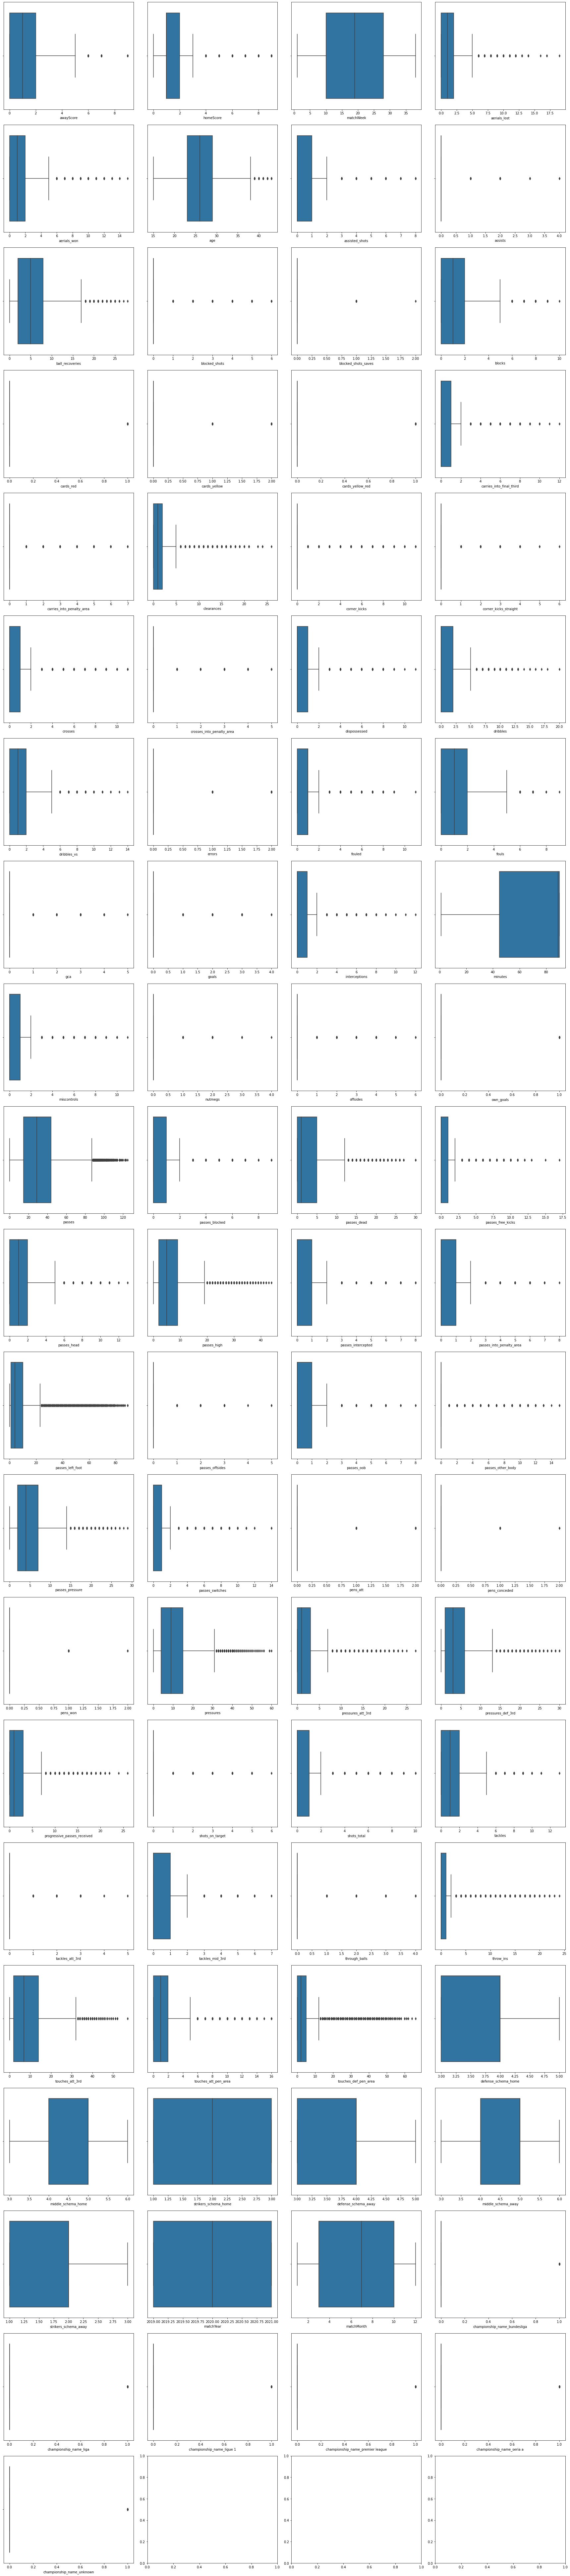

In [338]:
fig, axs = plt.subplots(21, 4, figsize = (24, 108))
axs = axs.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df, x=col, ax=axs[i])

plt.tight_layout()
plt.show()

It didn't remove rare but important values such as a lot of goals. It did what we wanted. 1.4 done

In [339]:
df.to_csv('../data/for_modellers/after_feature_engineering.csv', index=False)

In [376]:
df=pd.read_csv('../data/for_modellers/after_feature_engineering.csv')

## 1.5 Data transformation and scaling



In [360]:
df['matchMonth'] = df["matchMonth"].apply(lambda x: np.sin(x * (2 * np.pi / 12)))

df['matchYear'] = df['matchYear'].replace({2019: 0, 2020: 1, 2021: 2})

In [364]:
'''
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

pt = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()


df_transformed = pt.fit_transform(df)

df_scaled = scaler.fit_transform(df_transformed)

df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
'''

In [378]:

from sklearn.preprocessing import  MinMaxScaler

scaler = MinMaxScaler()


df_scaled = scaler.fit_transform(df)


df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [380]:
df_scaled.to_csv('../data/for_modellers/after_scaling.csv', index=False)

In [462]:
df=pd.read_csv('../data/for_modellers/after_scaling.csv')

# 2. Pre-modelling

In [382]:
from sklearn.cluster import KMeans
seed=42

In [465]:

def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=seed)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1
        scores.append(wcss)
    return scores

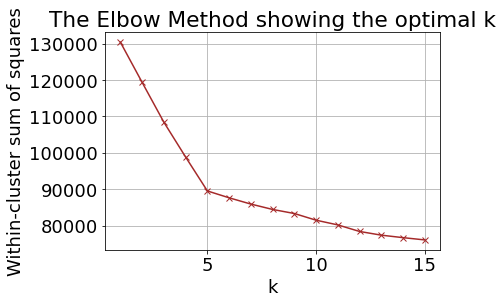

In [466]:
wcss_vec = count_wcss_scores(df, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.grid()
plt.show()

In [392]:
from sklearn.metrics import silhouette_score
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k, random_state = seed)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

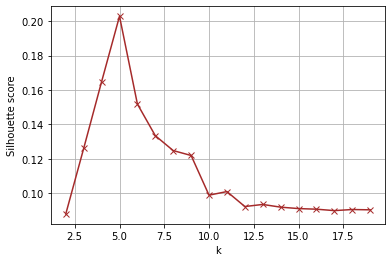

In [393]:
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'x-', color = "brown")
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()

In [428]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm
pca = PCA()
result = pca.fit_transform(df)


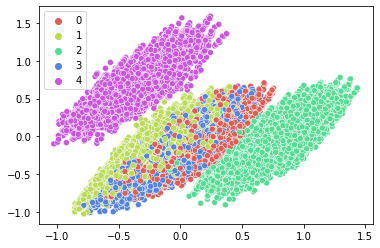

In [431]:
kmeans = KMeans(n_clusters=5, random_state=seed)
labels = kmeans.fit_predict(df)
sns.scatterplot(x = result[:, 0], y = result[:, 1], hue = labels[:], palette=sns.color_palette("hls", 5))
plt.show()

In [481]:
import plotly.express as px
import plotly.io as pio

# Assuming df is your DataFrame
pio.renderers.default = 'iframe'
# Perform PCA
pca = PCA()
result = pca.fit_transform(df)

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=seed)
labels = kmeans.fit_predict(df)

# Prepare DataFrame for plotting
for_plot = pd.DataFrame({f"{i}": result[:, i] for i in range(result.shape[1])})
for_plot['hue'] = pd.Series(labels).map(lambda x: str(x))

# Create the 3D scatter plot
fig = px.scatter_3d(for_plot, x='0', y='1', z='2', color='hue', category_orders={'hue': [str(i) for i in range(5)]})


[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [81] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[7]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot
[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.
[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


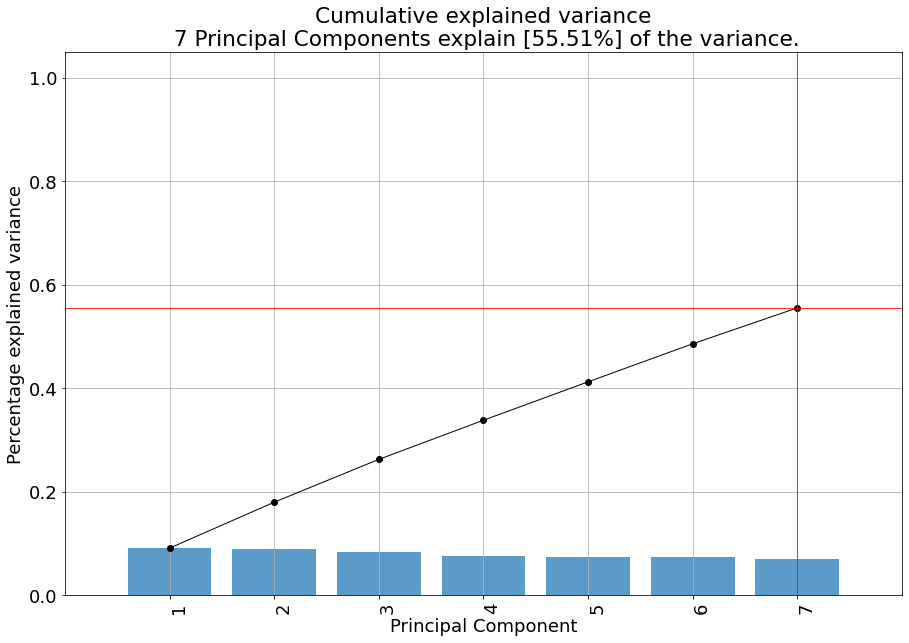

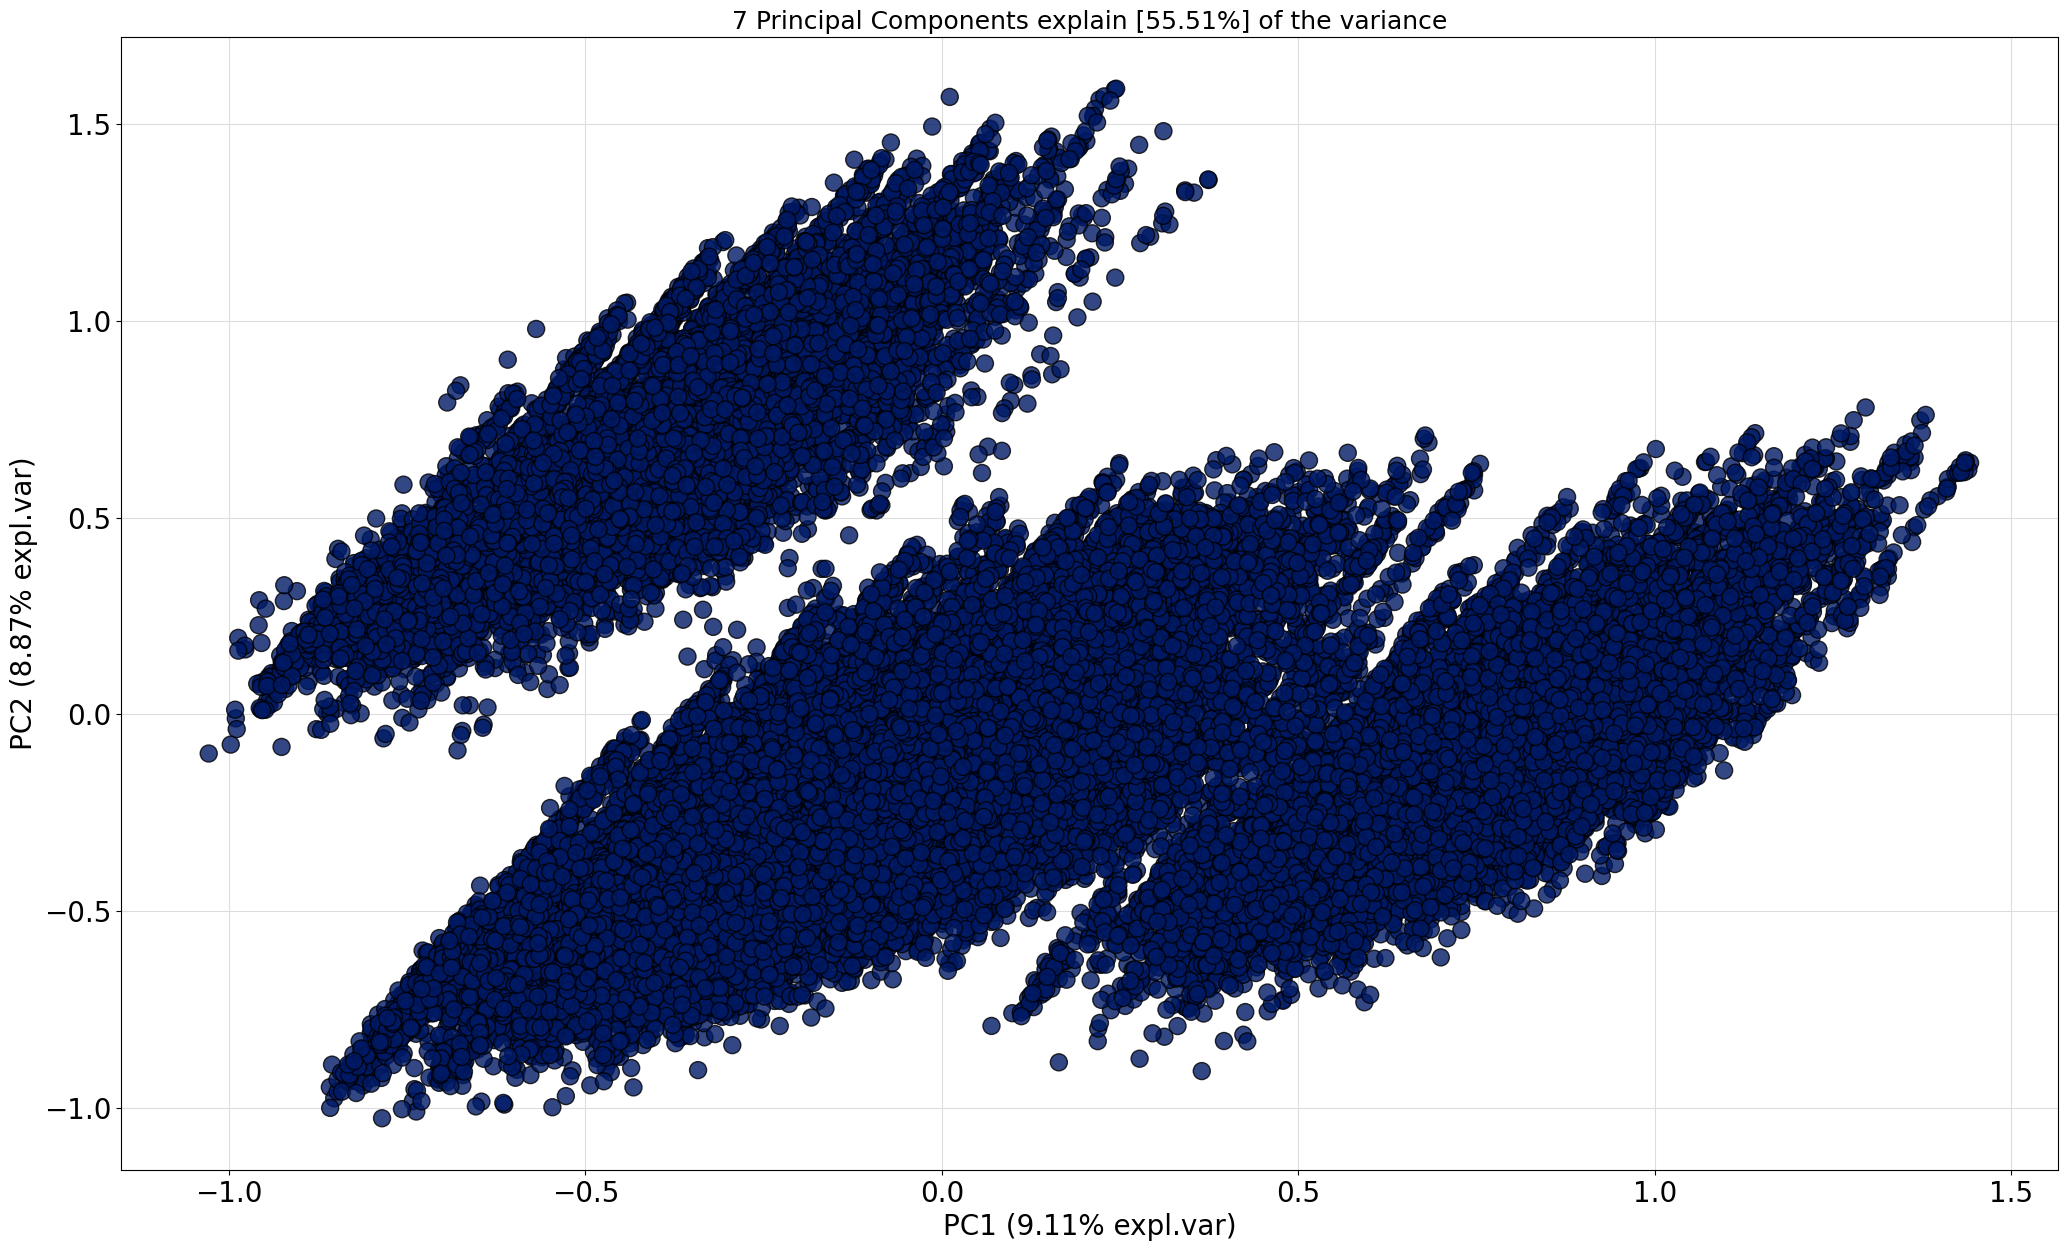

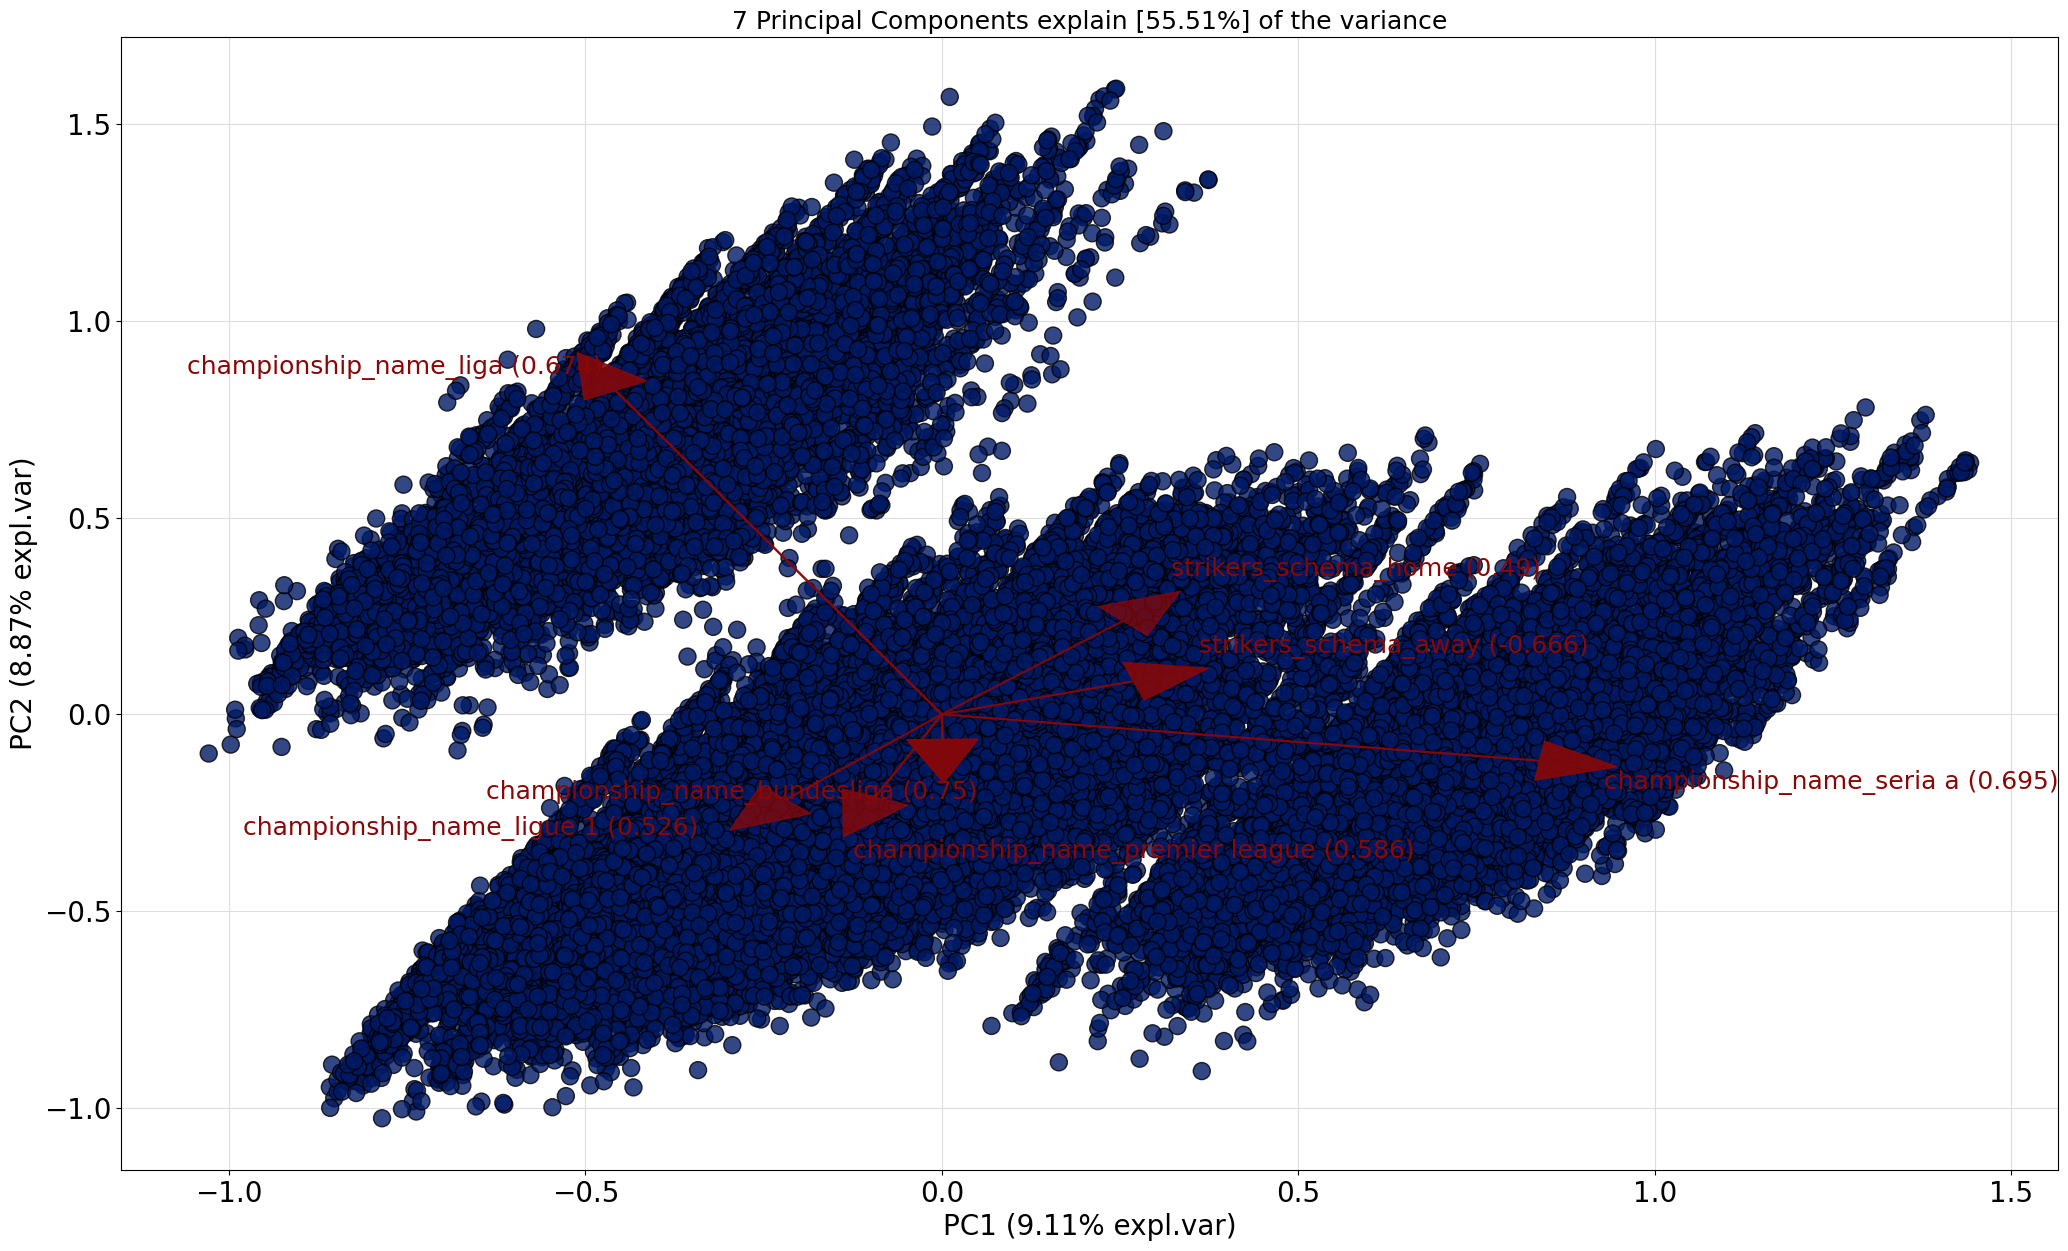

In [467]:
from pca import pca
# Or reduce the data towards 2 PCs
pca_2 = pca(n_components=7)
# Fit transform
results = pca_2.fit_transform(df)
# Plot explained variance
fig, ax = pca_2.plot()

# Scatter first 2 PCs
fig, ax = pca_2.scatter()

# Make biplot with the number of features
fig, ax = pca_2.biplot(n_feat=7)

In [470]:
import os
os.system('jupyter nbconvert --to html feature_engineering.ipynb')

0